In [1]:
from pyrocko import io,model
import os
import matplotlib.pyplot as plt
import numpy as np

reading event: flegrei_2023_06_11_06_44_25
reading event: flegrei_2023_09_07_17_45_28
reading event: flegrei_2023_09_26_07_10_29
reading event: flegrei_2023_10_02_20_08_26
reading event: flegrei_2024_04_27_03_44_56
reading event: flegrei_2024_05_22_06_28_00
reading event: flegrei_2024_06_08_01_52_04
reading event: flegrei_2024_06_18_01_58_24
reading event: flegrei_2024_07_26_11_46_21


/var/folders/_5/hfq6n3xn3n53jvjz81t_f2r80000gn/T/ipykernel_13819/960901288.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


reading event: flegrei_2024_08_30_19_23_15
len E : 60000, len N : 60001, len Z : 60001


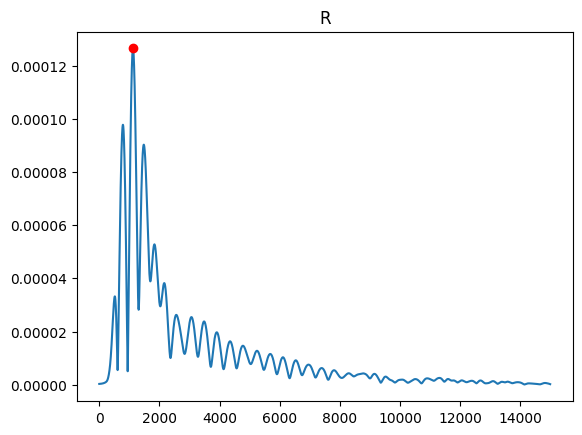

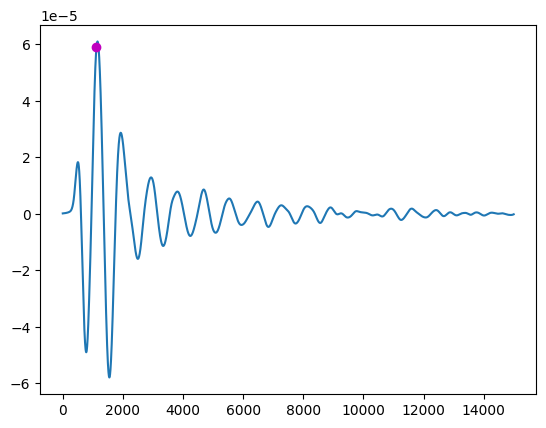

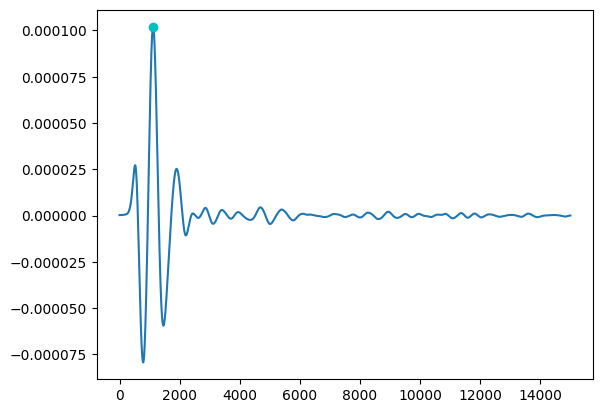

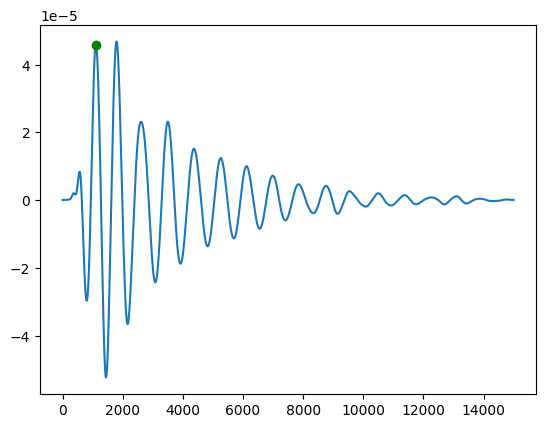

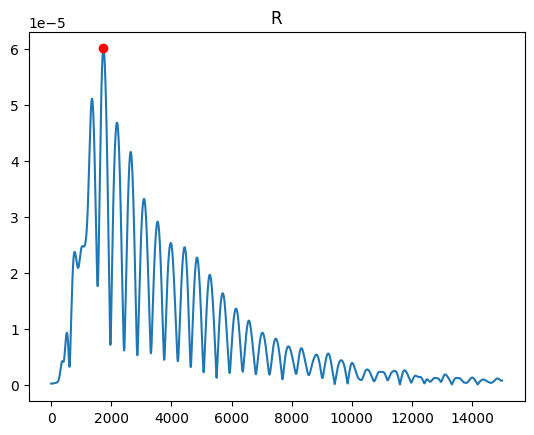

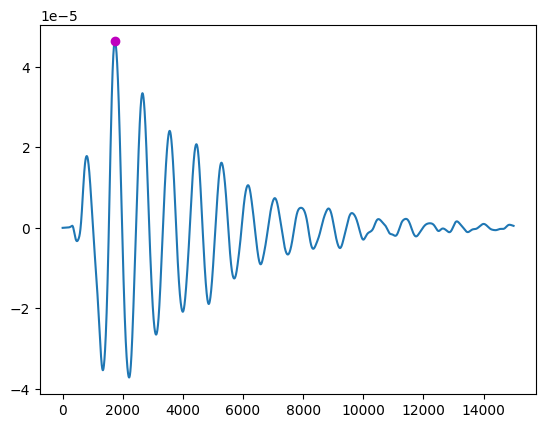

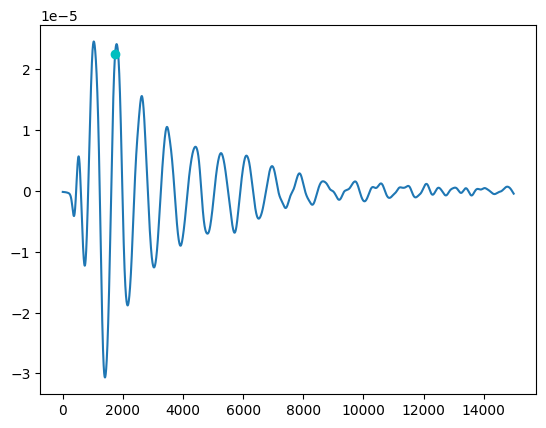

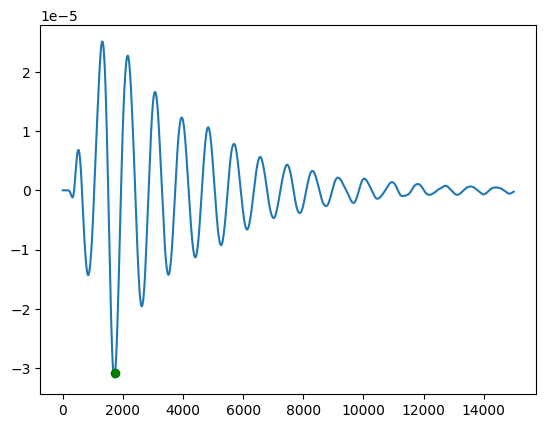

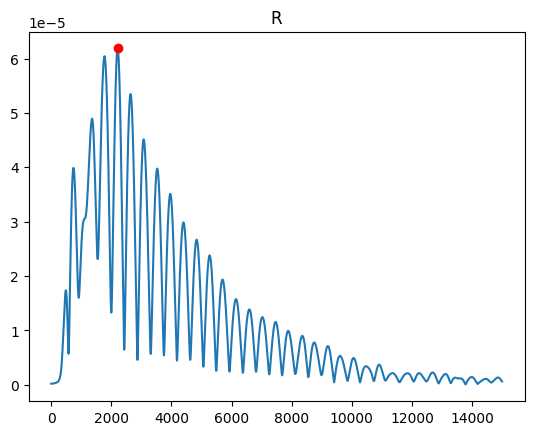

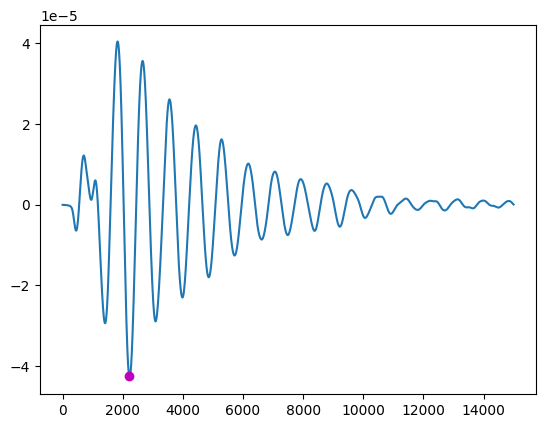

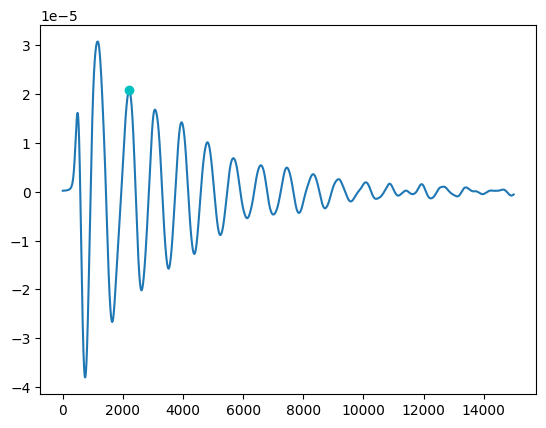

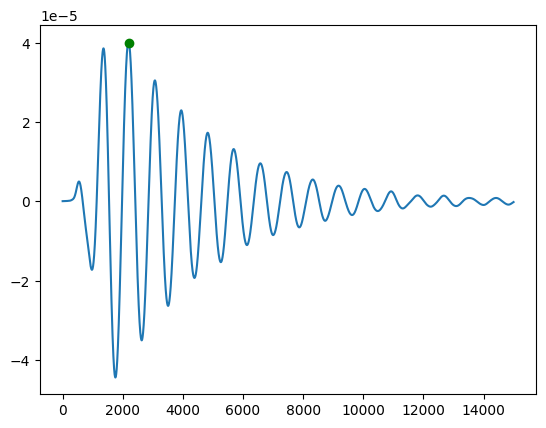

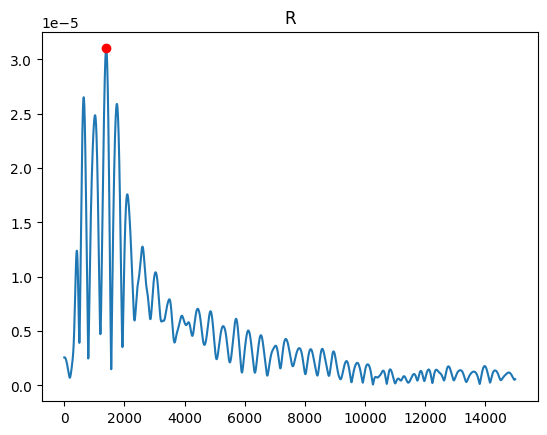

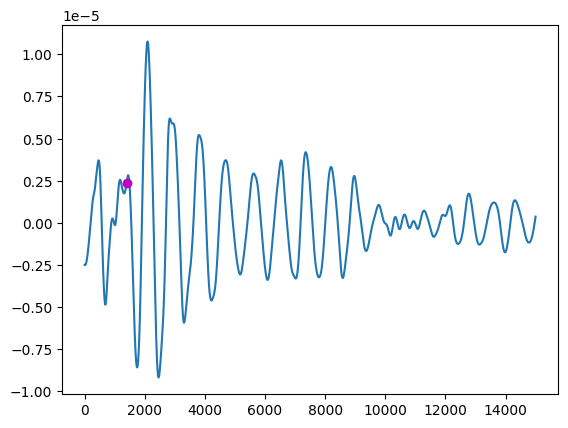

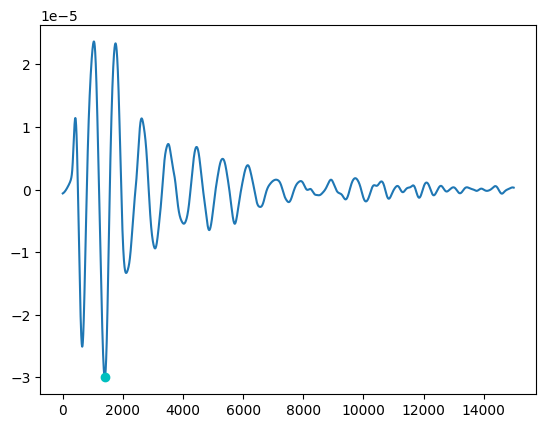

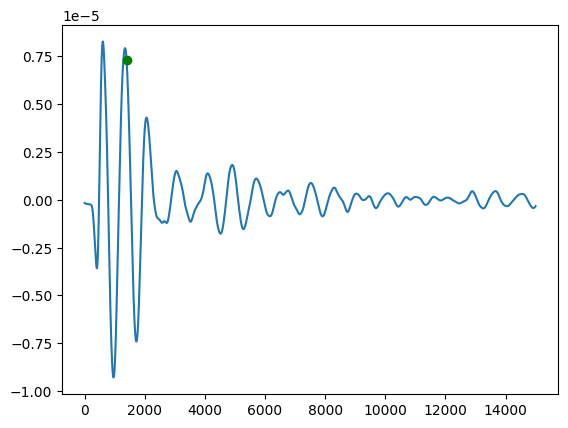

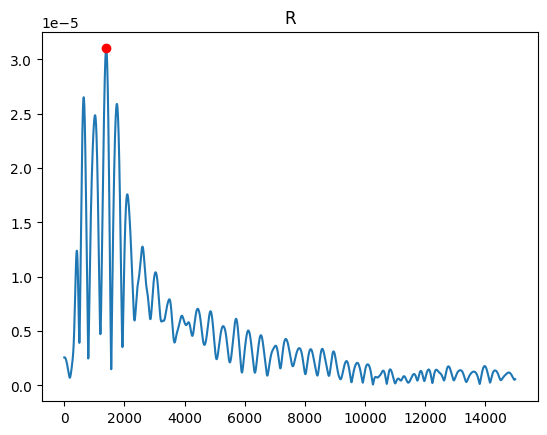

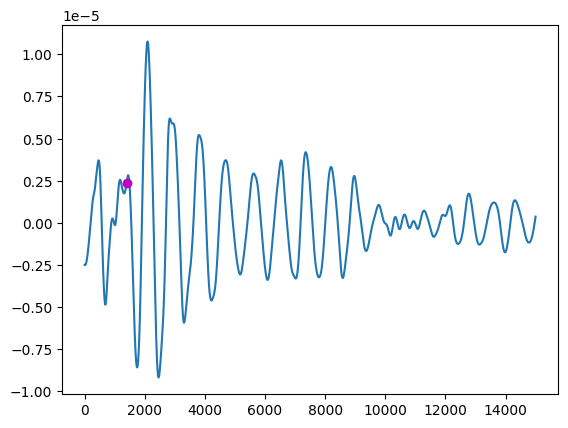

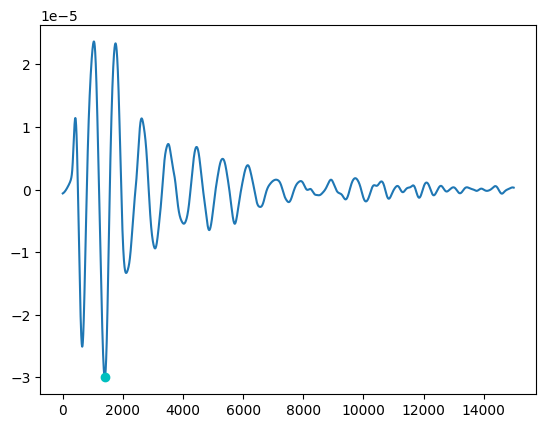

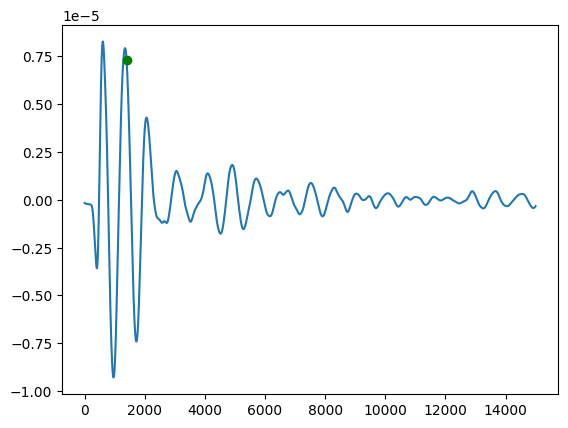

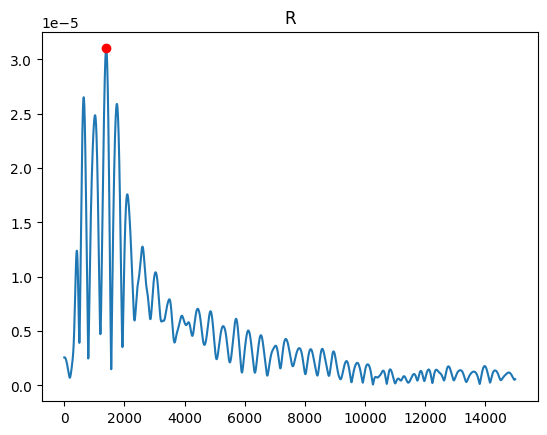

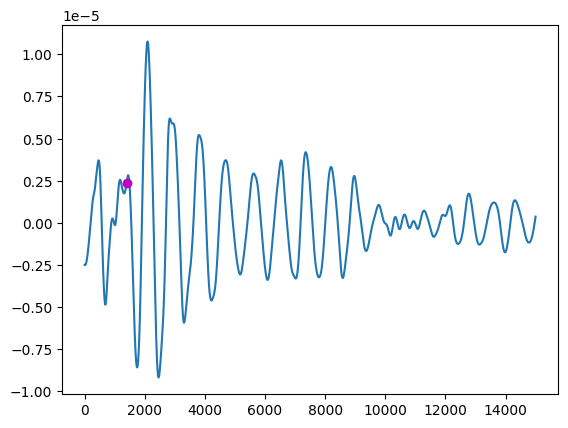

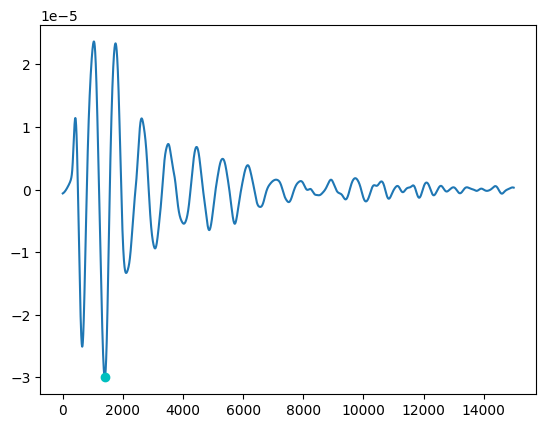

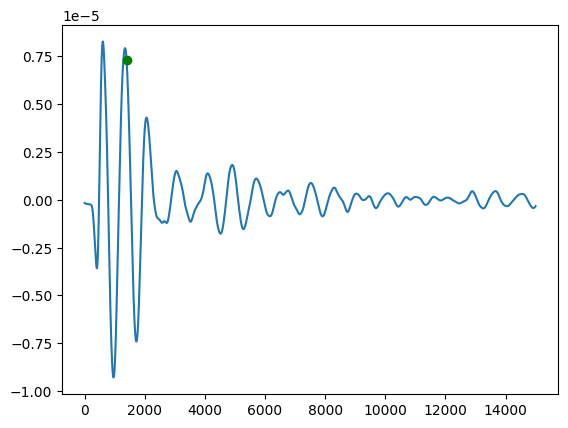

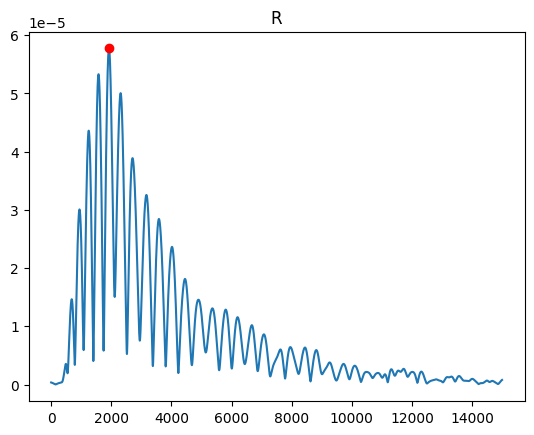

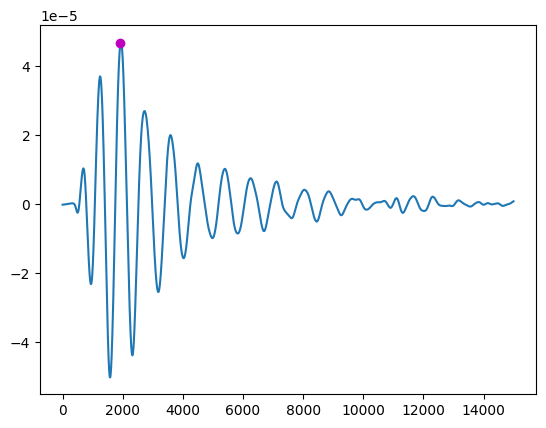

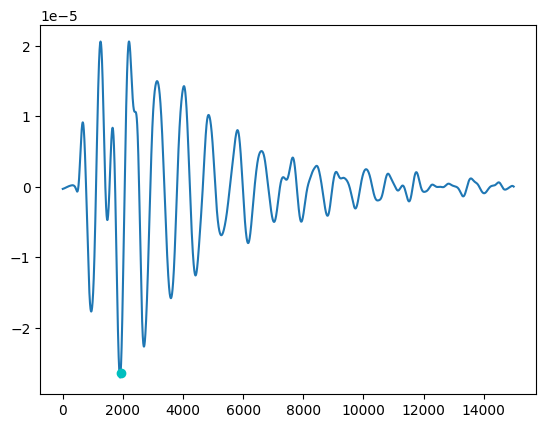

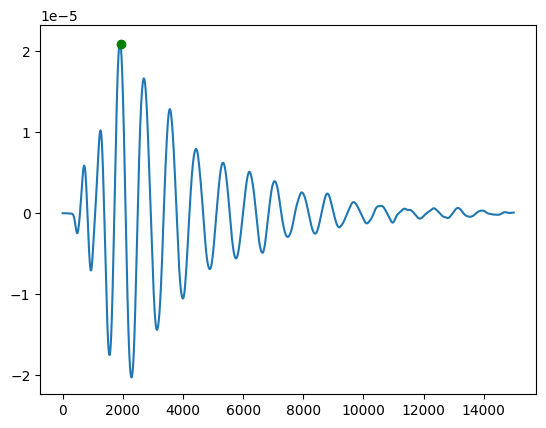

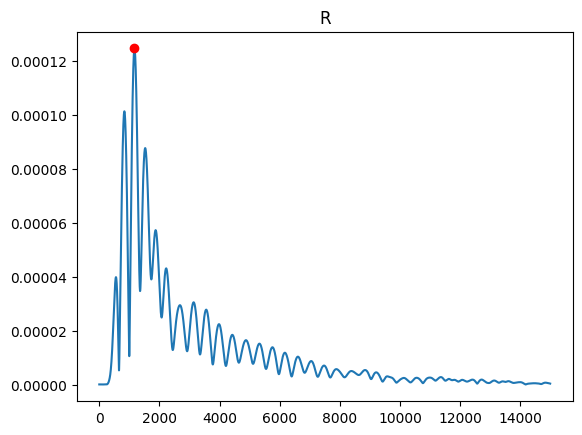

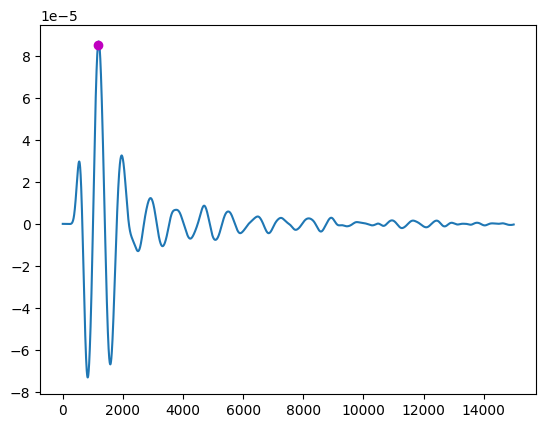

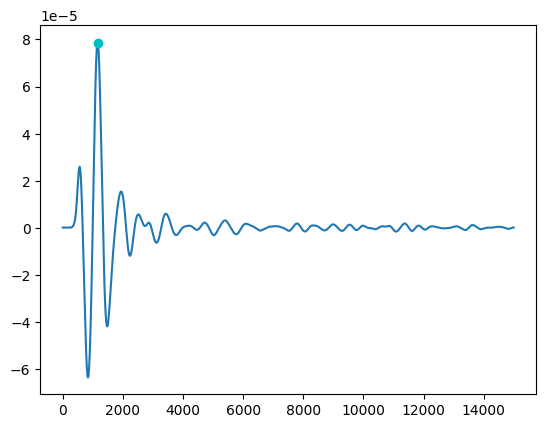

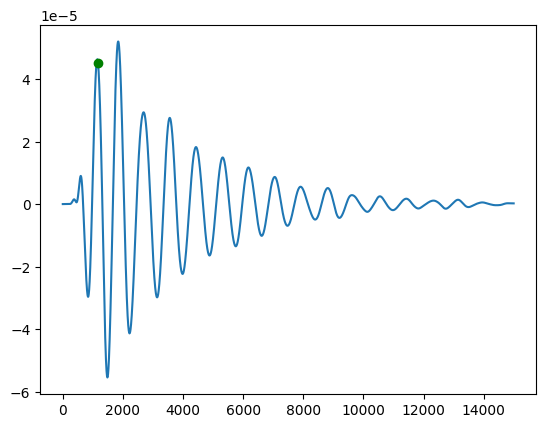

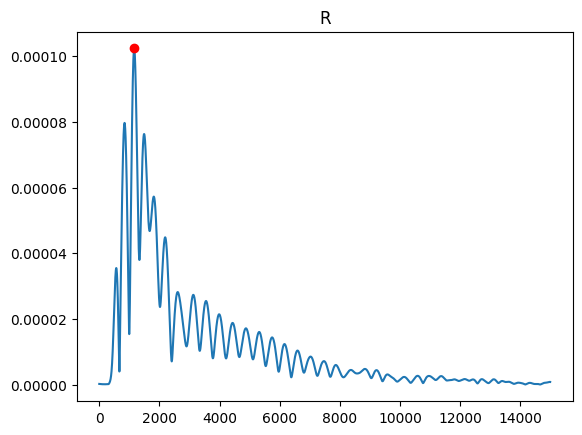

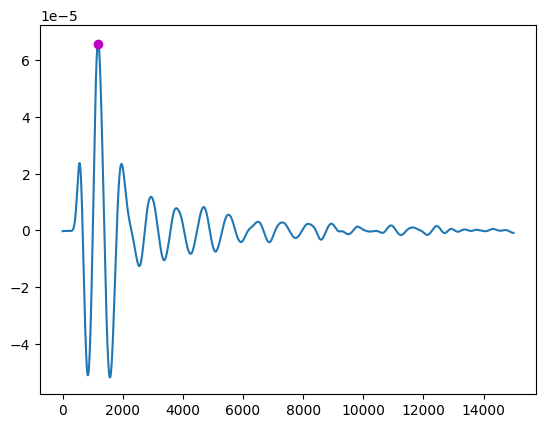

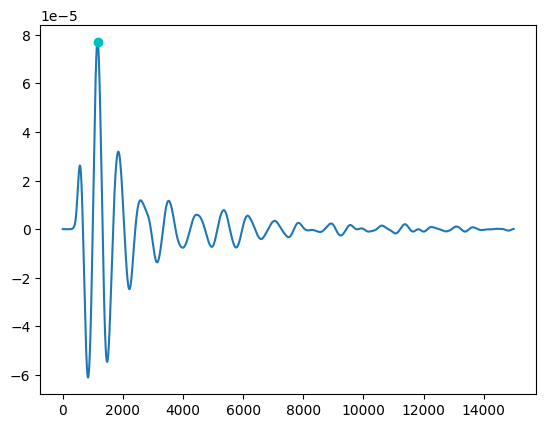

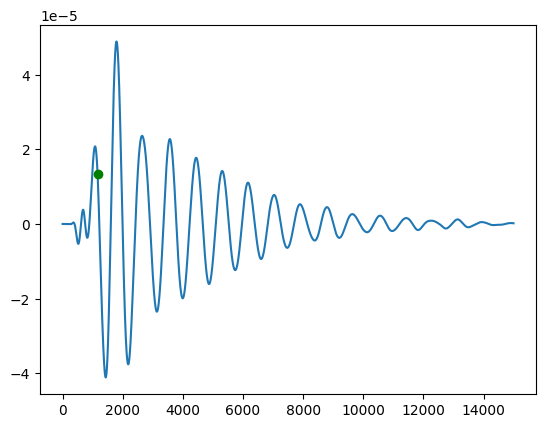

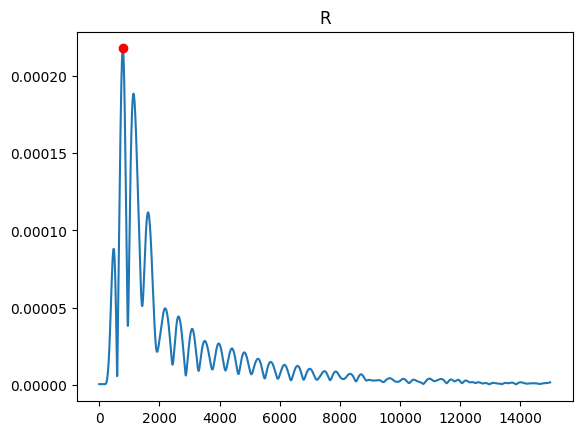

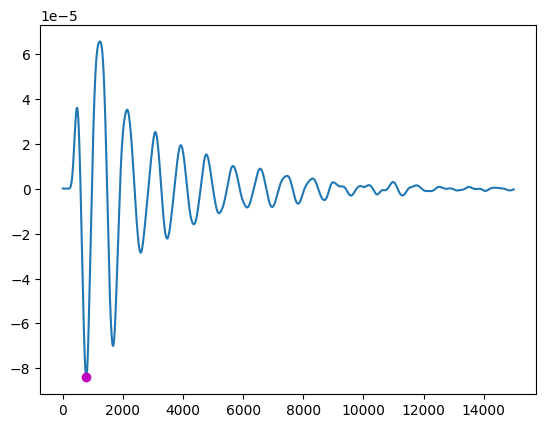

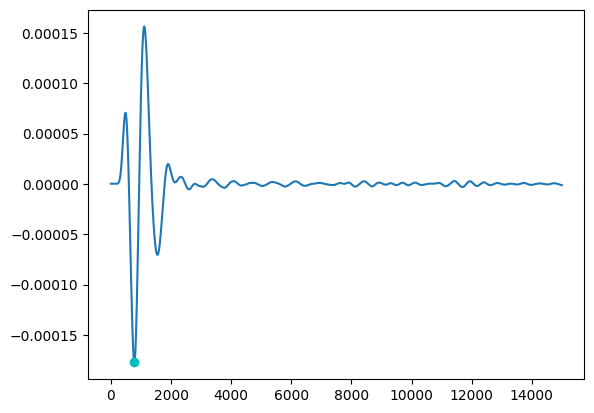

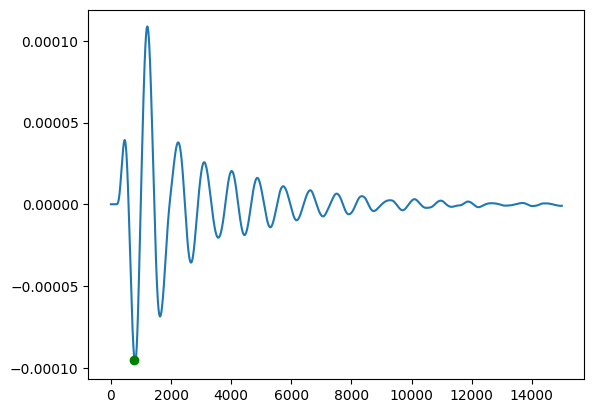

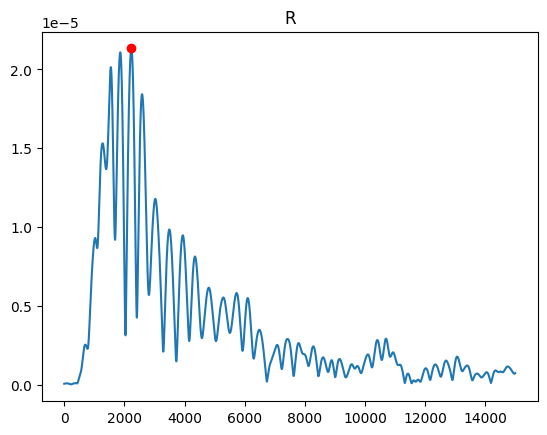

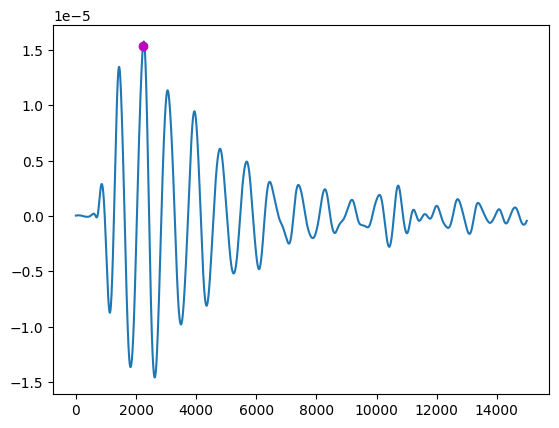

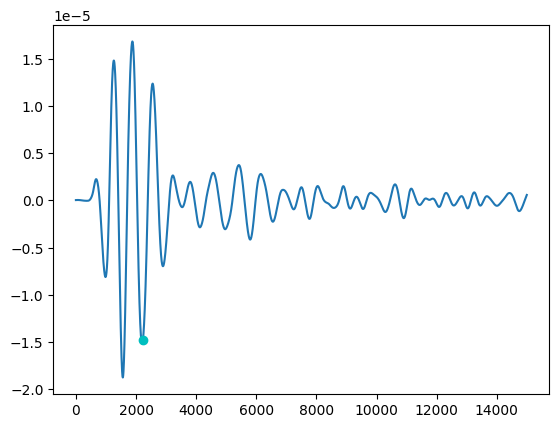

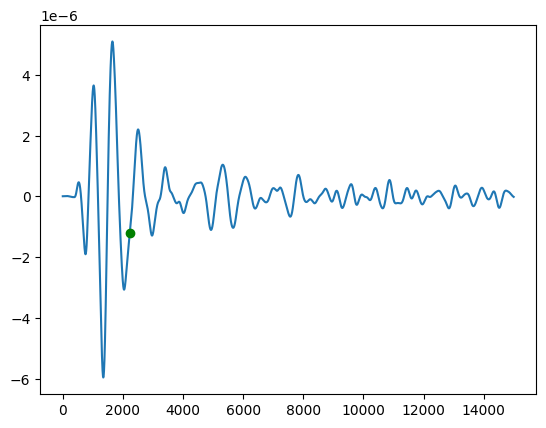

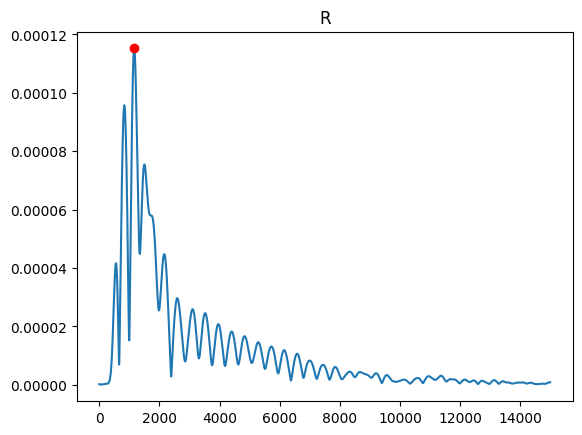

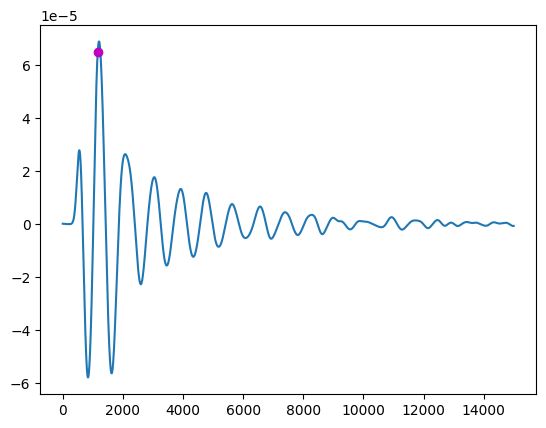

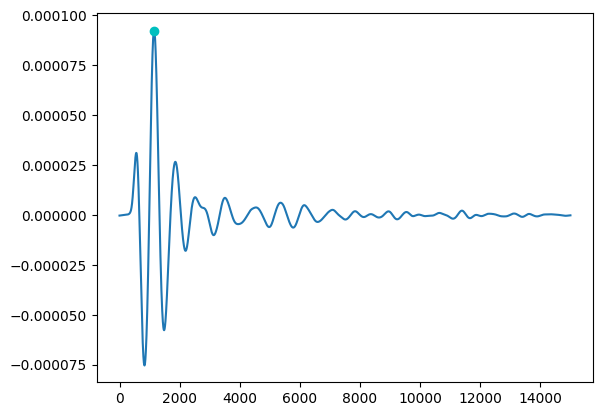

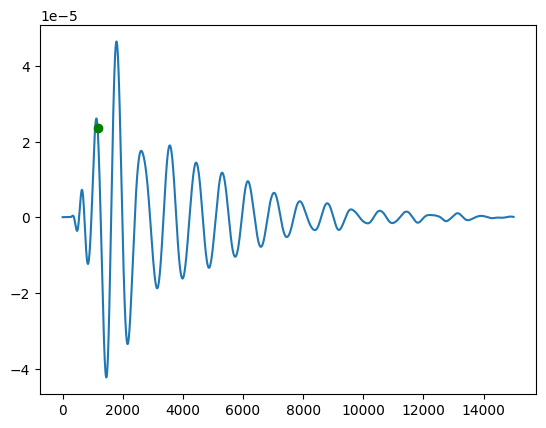

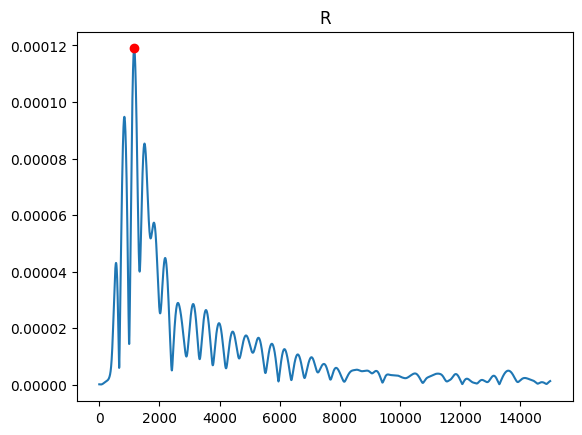

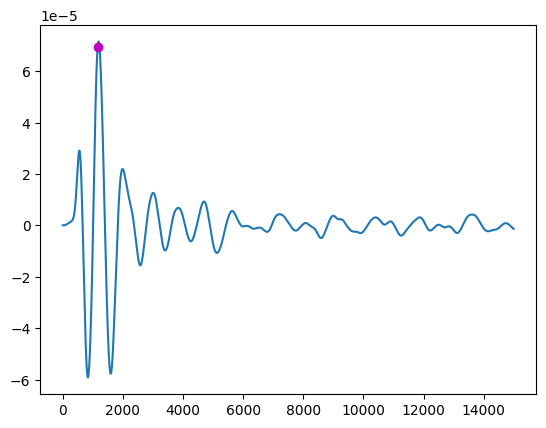

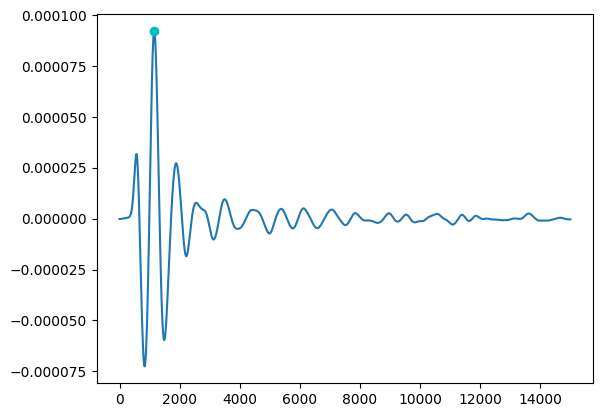

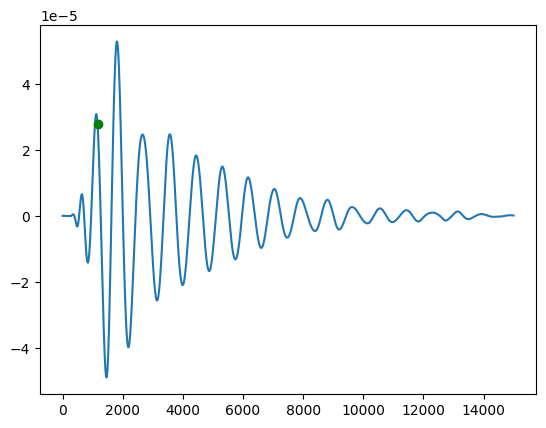

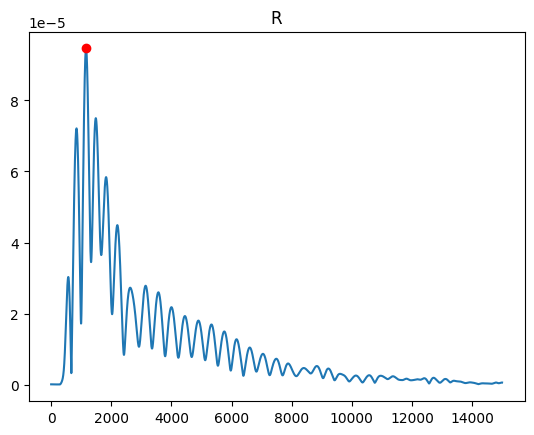

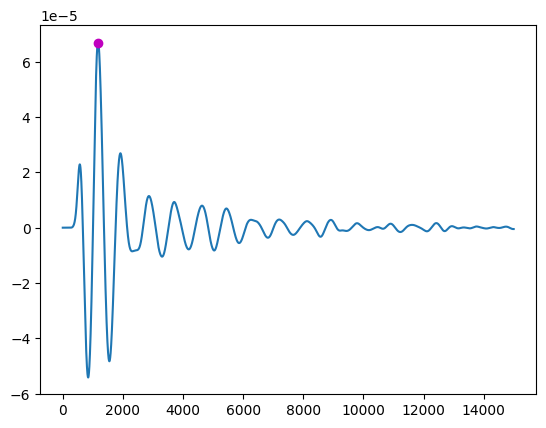

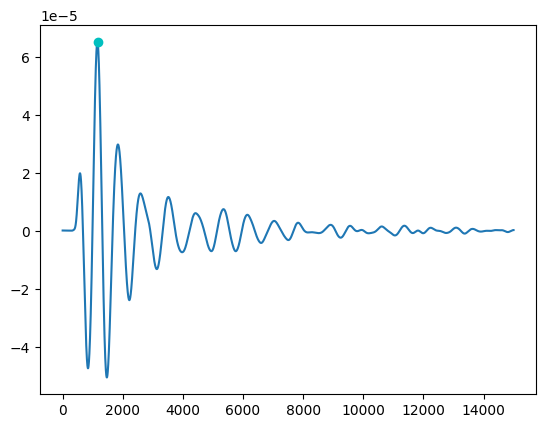

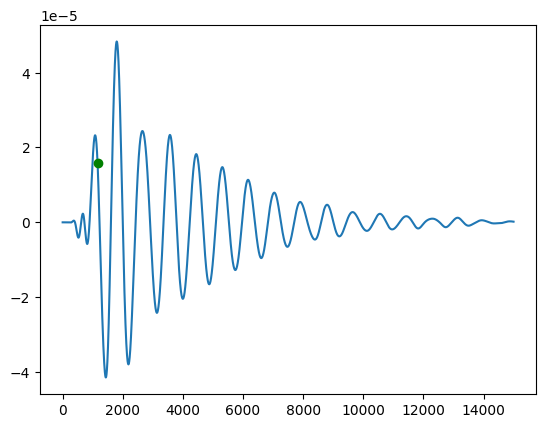

In [2]:
# data folder (response removed)
workdir='../'
datadir =  os.path.join(workdir,'DATA_VLP_response')

# events catalogue
catdir=os.path.join(workdir,'CAT')
catname=os.path.join(catdir,'catalogue_flegrei_VLP_gilberto.pf')
target_events=model.load_events(catname)

# stations list
stationsdir=os.path.join(workdir,'META_DATA')
stationsname=os.path.join(stationsdir,'stations_flegrei_INGV_final_near.pf')
stations=model.load_stations(stationsname)

# new file dir
newcatdir=os.path.join(catdir,'CRACK')

for targ_ev in target_events:
    event_name=targ_ev.name
    ev_dir = os.path.join(datadir, event_name)
    
    if not os.path.isdir(ev_dir):
        print(event_name, 'missing report dir', ev_dir)
    elif os.path.isdir(ev_dir):
        file_name = os.path.join(ev_dir,event_name + '.mseed' )
        traces = io.load(file_name)
        print(f'reading event: {event_name}')
        stations_dict = {key.station: [] for key in stations}
        max_values = {st.station: [] for st in stations}
        # add lat lon elevation
        for st in stations:
            max_values[st.station].append(st.lat)
            max_values[st.station].append(st.lon)
            max_values[st.station].append(st.elevation)

        for tr in traces:
            #filter trace
            tmp_filt_trace= tr
            tmp_filt_trace.lowpass(4,0.124)
            tmp_filt_trace.highpass(4,0.104)
            try:
                stations_dict[tr.station].append(tmp_filt_trace)
            except:
                continue
        for key in stations_dict:
            if len(stations_dict[key])==3:          # chack if stations has all 3 components
                # calculate vector length (r)
                e = stations_dict[key][0].ydata
                n = stations_dict[key][1].ydata
                z = stations_dict[key][2].ydata
                if len(e)==len(n)==len(z):
                    r = np.sqrt( e**2 + n**2 + z**2 )
                else:
                    min_len = np.min( [len(e),len(n),len(z)] )
                    r = np.sqrt( e[0:min_len]**2 + n[0:min_len]**2 + z[0:min_len]**2 )
                    print(f'WARNING: DIFFERENT TRACES LENGTH\nlen E : {len(e)}, len N : {len(n)}, len Z : {len(z)}')
                # find r MAX
                rmax=np.max(r)
                tmax=np.where(r==rmax)[0][0]
                emax=e[tmax]
                nmax=n[tmax]
                zmax=z[tmax]
                max_values[key].append(emax)
                max_values[key].append(nmax)
                max_values[key].append(zmax)

            '''
            if event_name == 'flegrei_2024_07_26_11_46_21':
                tmp=int(len(r)/4)
                plt.figure()
                plt.title('R')
                plt.plot(r[2*tmp:3*tmp])
                plt.plot(tmax-2*tmp,rmax,'or')

                plt.figure()
                plt.plot(e[2*tmp:3*tmp])
                plt.plot(tmax-2*tmp,emax,'om')

                plt.figure()
                plt.plot(n[2*tmp:3*tmp])
                plt.plot(tmax-2*tmp,nmax,'oc')

                plt.figure()
                plt.plot(z[2*tmp:3*tmp])
                plt.plot(tmax-2*tmp,zmax,'og')    
                '''
        # save file
        '''
        new_filename=os.path.join(newcatdir,event_name +'_max_displacement.txt')
        events_txt=[]
        for key in max_values:
            if len(max_values[key])==6:     # station has recorded traces    
                name=key
                lat= str(max_values[key][0])
                lon=str(max_values[key][1])
                elev=str(max_values[key][2])
                d_east=str(max_values[key][3])
                d_nord=str(max_values[key][4])
                d_z=str(max_values[key][5])
                events_txt.append(f'{name},{lat},{lon},{elev},{d_east},{d_nord},{d_z}')

        with open(new_filename, 'w') as output:
            output.write('station_name,latitude,longitude,elevation[m],d_east[m],d_nord[m],d_z[m]\n')
            for row in events_txt:
                output.write(str(row) + '\n')
            '''

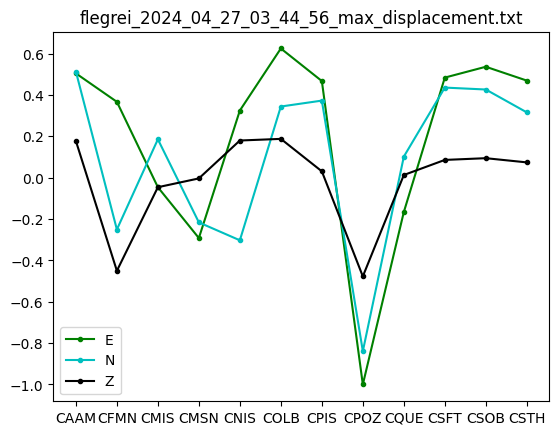

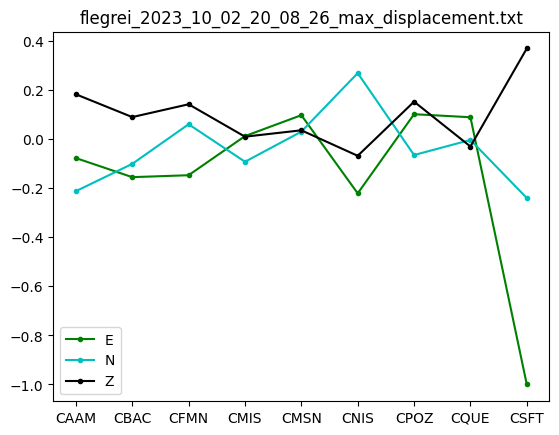

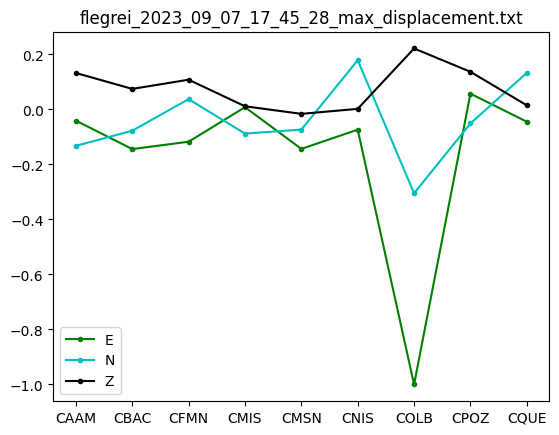

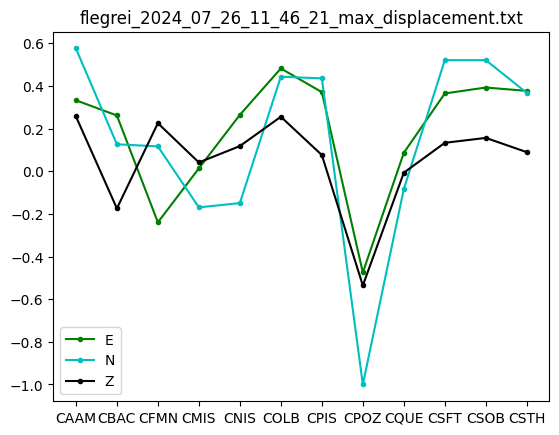

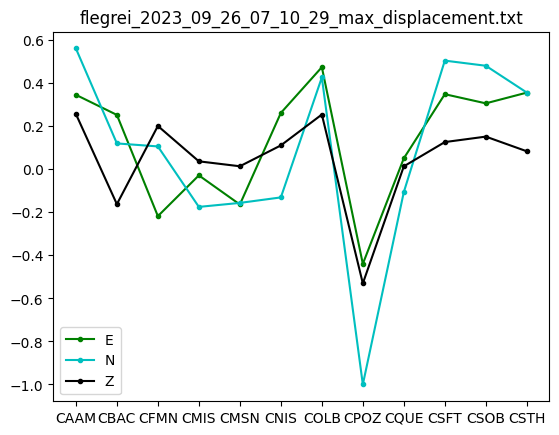

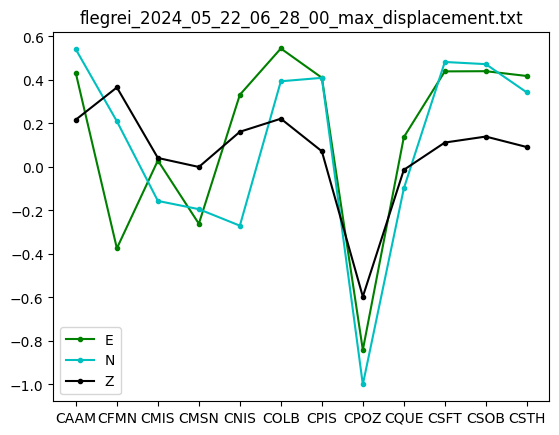

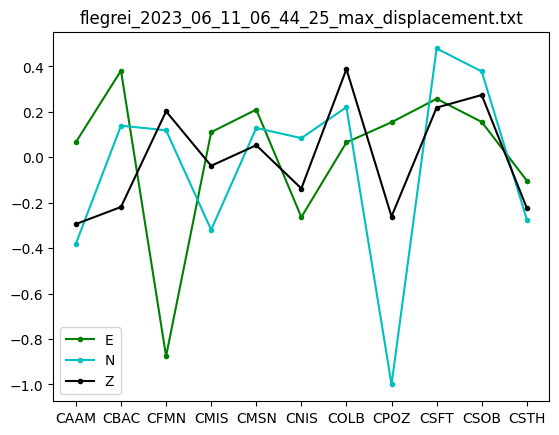

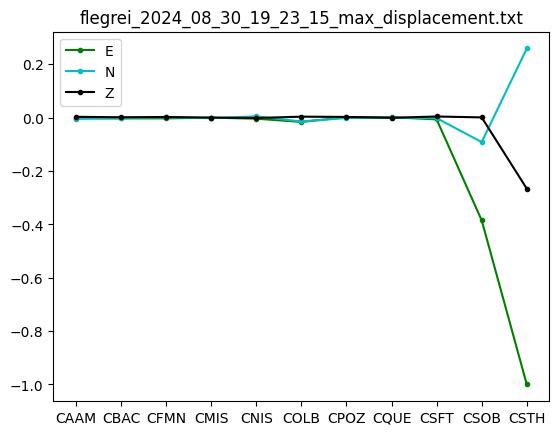

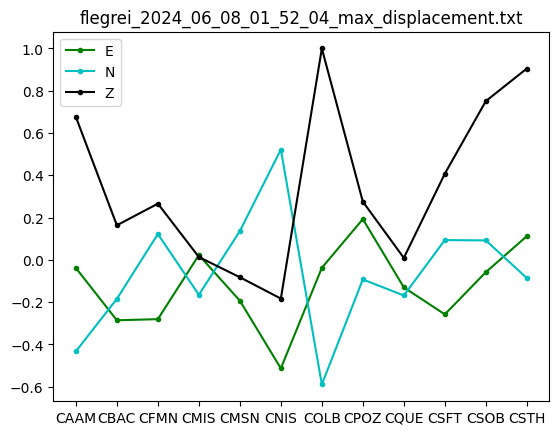

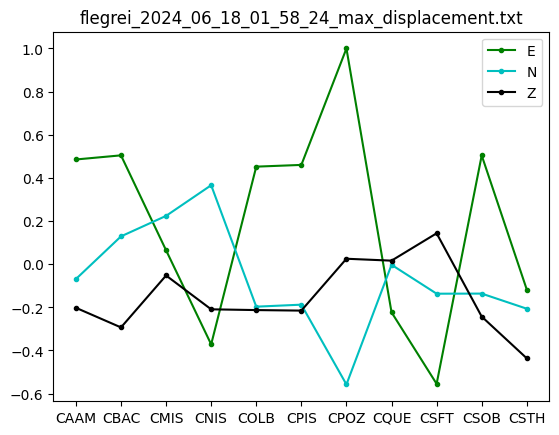

In [52]:
import pandas as pd

for file in os.listdir(newcatdir):
    #select event
    name = os.fsdecode(file)

    if name.startswith('.'): 
        continue
    else:
        ev_dir=os.path.join(newcatdir,name)
        data = pd.read_csv(ev_dir, sep=",", header=0)
        #print(data)
        val=[]
        val.append(np.array(data['d_east[m]']))
        val.append(np.array(data['d_nord[m]']))
        val.append(np.array(data['d_z[m]']))

        tmpmax=np.max(val)
        tmpmin=np.min(val)
        if tmpmax>np.abs(tmpmin):
            max_val=tmpmax
        else:
            max_val=tmpmin
        val = val / np.abs(max_val)

        x= np.arange(0,len(data['station_name']),1)
        x_ticks=[]
        for i in data['station_name']:
            x_ticks.append(i)        
        plt.figure()
        plt.xticks(x, x_ticks)
        plt.title(f'{name}')
        plt.plot(x,val[0],'.-g',label='E')
        plt.plot(x,val[1],'.-c',label='N')
        plt.plot(x,val[2],'.-k',label='Z')
        plt.legend()